# Análisis frecuencial

En muchas situaciones es conveniente descomponer las señales de interés (sonido, imaǵenes, etc.) en elementos "más simples". Estos elementos (la base de representación) pueden ser de muchos tipos, pero existe una base especial, "las frecuencias puras" (senos o cosenos), que son especialmente útiles. Esta descomposición se efectúa de forma eficiente con el algoritmo FFT.

El artículo de wikipedia [Fourier analysis](https://en.wikipedia.org/wiki/Fourier_analysis) tiene una buena introducción a este tema y a sus múltiples aplicaciones.

Estos vídeos del excelente canal 3blue1brown son muy recomendables:

- [Fourier Series: everything is rotations](https://www.youtube.com/watch?v=r6sGWTCMz2k)


- [Fourier visualized](https://www.youtube.com/watch?v=spUNpyF58BY)

## Bibliotecas y utilidades

In [2]:
import numpy             as np
import numpy.fft         as fft
import cv2               as cv
import skimage           as si
import matplotlib.pyplot as plt
import numpy.random      as rnd
import scipy.signal      as signal


%matplotlib inline

In [3]:
def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) / 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    plt.imshow(x, 'gray')

# para ver imágenes monocromas de float con rango fijo
def imshowf(x):
    plt.imshow(x, 'gray', vmin = 0, vmax=1)

# para ver imágenes con signo
def imshows(x,r=1):
    plt.imshow(x, 'gray', vmin = -r, vmax=r)

# ojo: filter2D no hace flip de la máscara (realmente hace correlación)
# (da igual en máscaras simétricas)
def conv(k,x):
    return cv.filter2D(x,-1,k)

# esta versión es correcta
def cconv(k,x):
    return signal.convolve2d(x, k, boundary='symm', mode='same')

def ft(x):
    return fft.fft2(x)

def ift(x):
    return fft.ifft2(x)

def centrafft(psf):
    h = psf.copy()
    r,c = psf.shape
    h = h[list(range(r//2,r)) + list(range(r//2)) ,:]
    h = h[:, list(range(c//2,c)) + list(range(c//2))]
    return h

## Ejemplo mínimo

El objetivo de esta sección es mostrar que el anális de frecuencias no es más que un cambio de base como los que se estudian en álgebra lineal (aunque en la práctica se efectúa con un algoritmo más eficiente).

Expresión de un vector en dos bases:

$$\begin{bmatrix}2\\-3\\8\\4\end{bmatrix}\; =\; 2 \begin{bmatrix}{\color{red}1}\\0\\0\\0\end{bmatrix} -3 \begin{bmatrix}0\\{\color{red}1}\\0\\0\end{bmatrix} + 8 \begin{bmatrix}0\\0\\{\color{red}1}\\0\end{bmatrix} + 4 \begin{bmatrix}0\\0\\0\\{\color{red}1}\end{bmatrix} \; =\; 5.5 \begin{bmatrix}0.5\\0.5\\0.5\\0.5\end{bmatrix} -4.3 \begin{bmatrix}0.65\\0.27\\-0.27\\-0.65\end{bmatrix} + 0.5 \begin{bmatrix}0.5\\-0.5\\-0.5\\0.5\end{bmatrix} + 6.6 \begin{bmatrix}0.27\\-0.65\\0.65\\-0.27\end{bmatrix}$$

La primera base es la canónica y la segunda es la DCT (que explicaremos después). (En este apartado usamos la base DCT porque trabaja con números reales.)

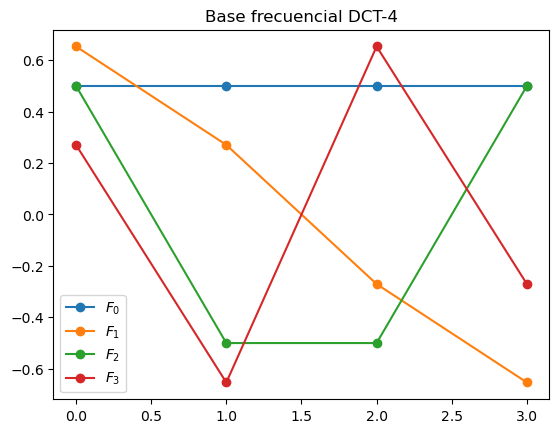

In [4]:
from scipy.fftpack import dct,idct

for k,v in enumerate([idct(v,norm='ortho') for v in np.eye(4)]):
    plt.plot(v,'o-',label='$F_{}$'.format(k))
plt.legend();
plt.title('Base frecuencial DCT-4');

La de tamaño 8 es más fácil de interpretar:

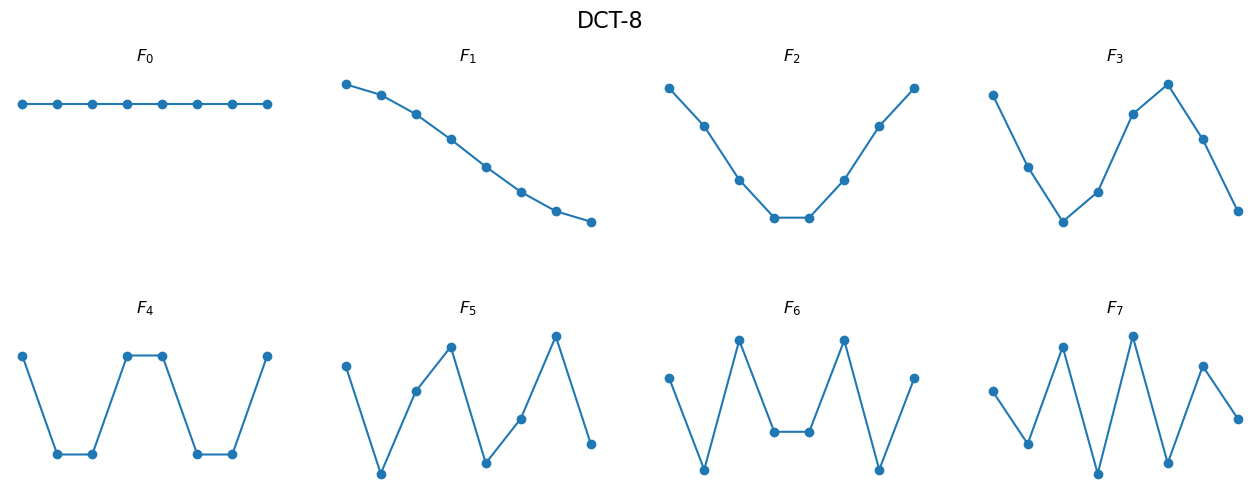

In [5]:
plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace=0.5)
for k,v in enumerate([idct(v,norm='ortho') for v in np.eye(8)]):
    plt.subplot(4,4,k+1)
    plt.plot(v,'o-'); plt.ylim(-.6,.6)
    plt.title('$F_{}$'.format(k)); plt.grid(); plt.axis('off')
plt.suptitle('DCT-8',y=0.93,fontsize=16);

Volvemos a la dimensión 4 y hacemos algunas comprobaciones. Definimos las dos bases:

In [6]:
B = np.array([v for v in np.eye(4)])
F = np.array([idct(v,norm='ortho') for v in np.eye(4)])

inv = np.linalg.inv

In [7]:
B

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [8]:
F

array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ],
       [ 0.65328148,  0.27059805, -0.27059805, -0.65328148],
       [ 0.5       , -0.5       , -0.5       ,  0.5       ],
       [ 0.27059805, -0.65328148,  0.65328148, -0.27059805]])

Estas matrices contienen los elementos de las bases por filas, de modo que podemos extraerlos con el primer índice:

In [9]:
F[1]

array([ 0.65328148,  0.27059805, -0.27059805, -0.65328148])

Un vector cualquiera es la combinación lineal de la base con sus coordenadas. En la base canónica:

In [10]:
x = np.array([2,-3,8,4])

(Recordemos que para expresar una combinación lineal de vectores de forma matricial podemos poner los vectores en una matriz por filas y multiplicamos los coeficientes por la izquierda. O ponemos los vectores de la base por columnas y multiplicamos las coordenadas por la derecha.)

In [11]:
x @ B

array([ 2., -3.,  8.,  4.])

Cambiamos de base:

In [12]:
inv(F).T @ x

array([ 5.5       , -4.28314152,  0.5       ,  6.64490021])

In [13]:
x @ inv(F)

array([ 5.5       , -4.28314152,  0.5       ,  6.64490021])

Como la base es ortonormal la inversa y la traspuesta coinciden:

In [14]:
y = F @ x
y

array([ 5.5       , -4.28314152,  0.5       ,  6.64490021])

In [15]:
y = x @ F.T
y

array([ 5.5       , -4.28314152,  0.5       ,  6.64490021])

La transformada DCT realiza esta operación de forma mucho más eficiente (se aprecia en dimensión grande).

In [16]:
dct(x,norm='ortho')

array([ 5.5       , -4.28314152,  0.5       ,  6.64490021])

El vector original es el mismo, aunque sus coordenadas dependen de la base:

In [17]:
y @ F

array([ 2., -3.,  8.,  4.])

In [18]:
x @ B

array([ 2., -3.,  8.,  4.])

Claro, te puedo explicar con más detalle la serie de Fourier y cómo se utiliza para descomponer señales en sus componentes de frecuencia.

La serie de Fourier es una herramienta matemática que permite descomponer una función periódica en una serie infinita de funciones sinusoidales, cada una con una frecuencia diferente. Estas funciones sinusoidales se llaman armónicos y son múltiplos enteros de la frecuencia fundamental de la señal.

La serie de Fourier se puede representar matemáticamente como:


donde $\omega_0 = \frac{2\pi}{T}$ es la frecuencia fundamental de la señal, T es el período de la señal, $a_0, a_n$ y $b_n$ son coeficientes que se calculan a partir de la función f(x), y n es un entero positivo que indica el número de armónicos.

En la expresión que presentaste, se utilizó una versión simplificada de la serie de Fourier que solo considera los armónicos cosenos. Esta versión se puede representar como:


donde $\omega$ es la frecuencia del armónico, $A_{\omega}$ es la amplitud del armónico, y $\phi_{\omega}$ es la fase del armónico.

La serie de Fourier es útil porque permite descomponer una señal en sus componentes de frecuencia. Cada término en la serie representa un armónico con una frecuencia y una amplitud específicas, lo que permite identificar las frecuencias que contribuyen a la señal original.

Por ejemplo, si se aplica la serie de Fourier a una señal de audio, se pueden identificar las frecuencias de las notas musicales que se están tocando en la señal. Esto es útil para la transcripción de música y para la eliminación de ruido en la señal.

En resumen, la serie de Fourier es una herramienta matemática poderosa que se utiliza para descomponer señales en sus componentes de frecuencia. La serie se puede representar como una suma infinita de armónicos sinusoidales, cada uno con una frecuencia y una amplitud específicas. La serie de Fourier se utiliza en el análisis y procesamiento de señales para identificar las frecuencias que contribuyen a una señal y para eliminar el ruido de la señal.

## La base de Fourier

Cualquier señal se puede expresar como una combinación de ondas de diferentes frecuencias.

$$ f(x) = \sum_\omega A_\omega \cos(2\pi \omega x + \phi_\omega) $$

Cada frecuencia $\omega$ contribuye con una cierta amplitud $A_\omega$ y desplazamiento $\phi_\omega$. La Transformada de Fourier es un algoritmo que analiza la señal y obtiene estos dos ingredientes.

Por conveniencia matemática es mucho mejor usar ondas complejas

$$ f(x) = \sum _ \omega F_\omega  e ^ {2 \pi i \omega x} $$

donde los coeficientes codifican en un número complejo la amplitud y el desplazamiento de cada frecuencia.

$$ F_\omega = A e^{i \phi_\omega} $$

Hay una explicación más detallada en [este documento](https://robot.inf.um.es/material/va/percep.pdf#appendix.B), que incluye también una interpretación geométrica de la base de exponenciales complejas. (Son unos apuntes de cursos anteriores de esta asignatura, que están pendientes de actualizar y convertir en notebooks interactivos.)

Como ejemplo, generamos una señal con componentes frecuenciales conocidas y vemos como la FFT las encuentra:

In [19]:
# componente frecuencial de amplitud a, frecuencia w y fase d
def C(w,d,x):
    return np.cos(2*np.pi*w*x+d)

def fun(x):
    return 1 + 3*C(2,0.1,x) + 4*C(5,-0.2,x) + 2*C(15,0.3,x)

x = np.linspace(0,1,1000)

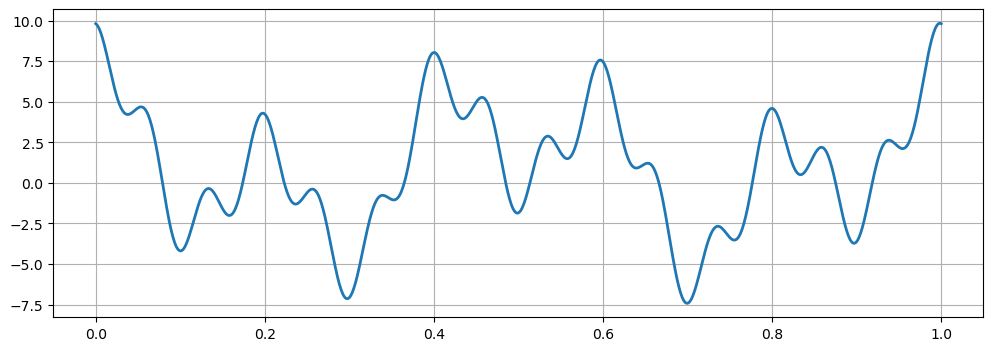

In [20]:
fig(12,4)
plt.plot(x,fun(x),lw=2);
plt.grid();

La hemos conseguido sumando las siguientes componentes:

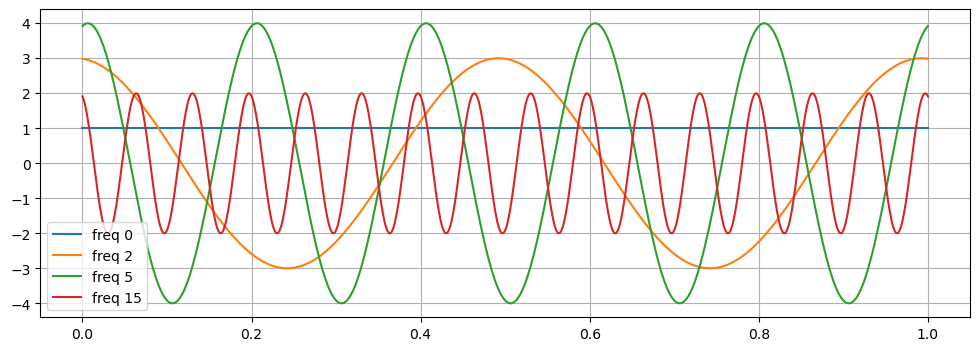

In [21]:
fig(12,4)
plt.plot(x,1*C(0,0,x), label='freq 0')
plt.plot(x,3*C(2,0.1,x), label='freq 2')
plt.plot(x,4*C(5,-0.2,x), label='freq 5')
plt.plot(x,2*C(15,0.3,x), label='freq 15');
plt.grid(); plt.legend();

En la práctica, solo observamos un muestreo de la señal:

[ 9.81595179  6.30286858  4.24035093  4.40848432 -0.32957162 -4.19336136
 -1.59759719 -0.62238073 -1.97947832  1.54265739  4.23997162  0.6004706
 -1.23016223 -0.48641156 -4.34128591 -7.0698233  -3.15806809 -0.76881047
 -0.70266617  4.16248461  8.03820054  5.33844453  4.14985238  5.19759762
  1.28957065 -1.84592679  1.33063173  2.70265116  1.53343255  5.02271813
  7.46851721  3.37463965  0.91531904  0.89557345 -3.80963236 -7.42190696
 -4.37176625 -2.767862   -3.36146333  1.01100384  4.59205528  1.81416876
  0.76888931  2.17238559 -1.18980513 -3.62367804  0.36620768  2.6121526
  2.32254585  6.6418604 ]


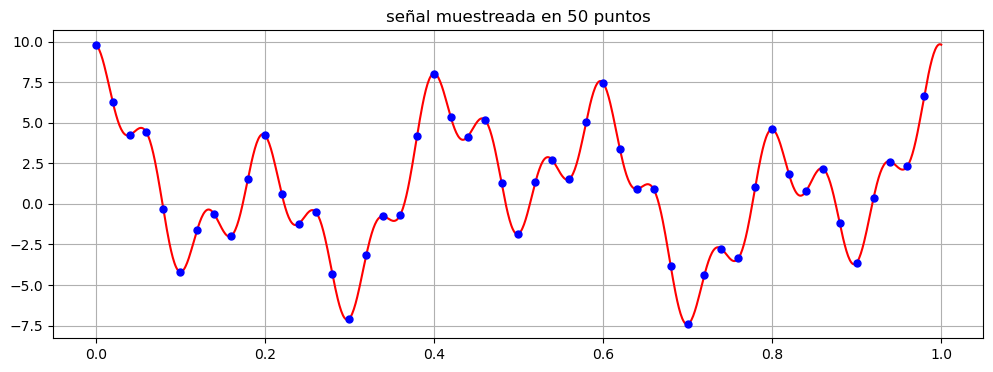

In [22]:
delta = 0.02
xs =  np.linspace(0,1-delta,50)
f = fun(xs)

print(f)

fig(12,4)
plt.plot(x,fun(x),'r',xs,f,'.b',markersize=10); plt.grid()
plt.title('señal muestreada en 50 puntos');

El algoritmo FFT (transformada discreta rápida de Fourier) analiza la señal muestreada y devuelve las amplitudes y fases de los componentes, aunque lo hace de forma un poco especial, codificadas como módulo y argumento de números complejos, y situadas en dos posiciones del array resultante.

In [23]:
# dividimos por n para que la escala global de la FFT coincida con las amplitudes
F = fft.fft(f)/len(f)

# para visualizar mejor el array, quitamos los ceros numéricos
F[abs(F)<1E-10] = 0

F

array([1.        +0.j        , 0.        +0.j        ,
       1.49250625+0.14975012j, 0.        +0.j        ,
       0.        +0.j        , 1.96013316-0.39733866j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.95533649+0.29552021j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.95533649-0.29552021j,
       0. 

Vamos a manipular un poco el array para extraer las componentes de la señal.

El módulo del resultado:

In [24]:
abs(F)

array([1. , 0. , 1.5, 0. , 0. , 2. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 2. , 0. , 0. , 1.5, 0. ])

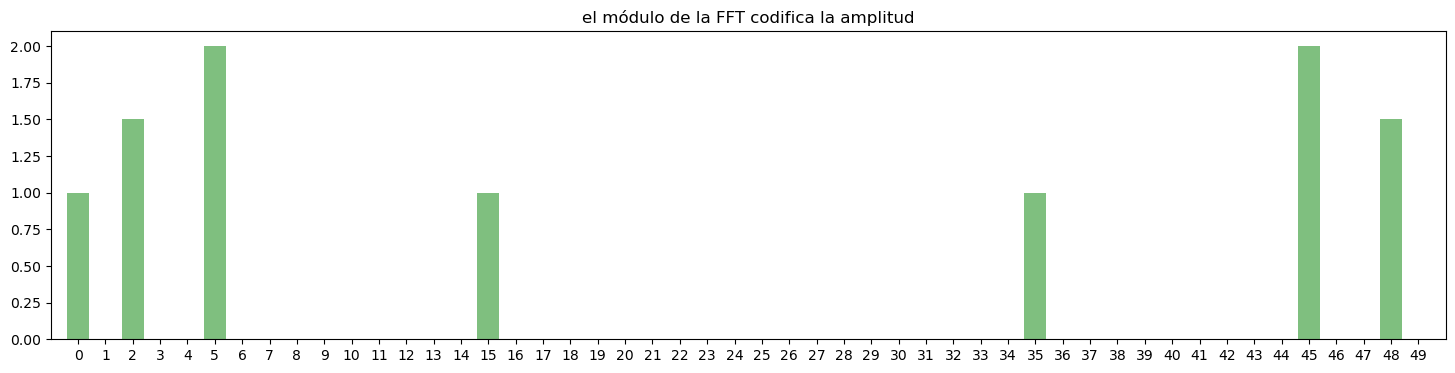

In [25]:
w = np.array(range(len(F)))
fig(18,4)
plt.bar(w,abs(F), color='green',alpha=0.5)
plt.xticks(w); plt.axis([-1,50,0,2.1]);
plt.title('el módulo de la FFT codifica la amplitud');

Y la fase:

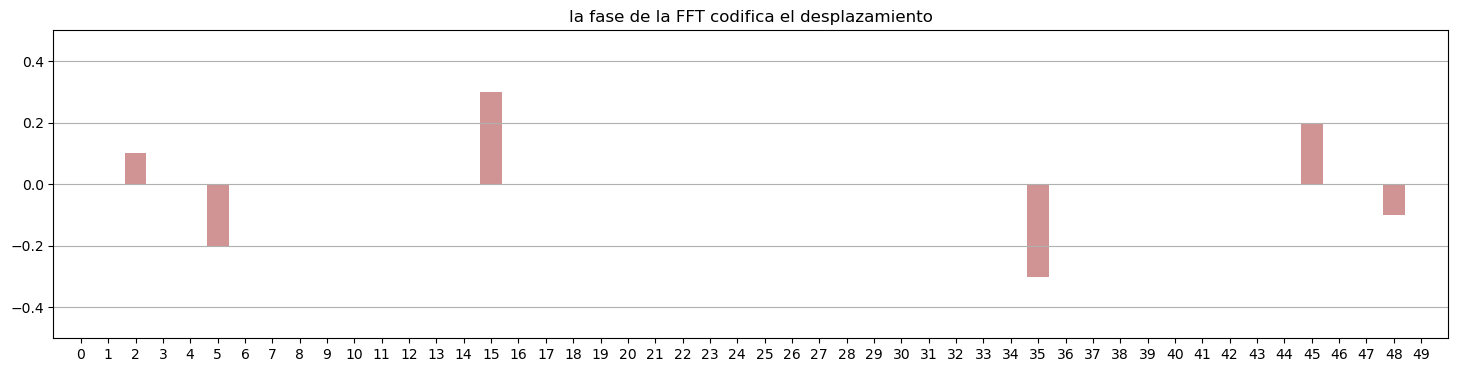

In [26]:
w = np.array(range(len(F)))
fig(18,4)
plt.bar(w,np.angle(F), color='brown',alpha=0.5)#Fase de la transformada de furrier
plt.xticks(w); plt.axis([-1,50,-0.5,0.5]);
#plt.grid()
plt.title('la fase de la FFT codifica el desplazamiento');
plt.grid(axis='y')

Vemos que la magnitud de la transformada de Fourier, que es una señal compleja, contiene la amplitud de cada onda $A_\omega$, y la "fase" es el desplazamiento $\phi_\omega$. Observa que cada frecuencia $\omega$ aparece en la transformada en dos posiciones, correspondientes a $\omega$ y $-\omega$ (que en realidad son la misma onda), y que las frecuencias negativas aparecen al final del vector.

La FFT es periódica y por tanto las frecuencias superiores a $N/2$ (la máxima que se puede detectar) equivalen a frecuencias negativas. Lo normal es mostrar "rotada" o "centrada" la fft para poner las frecuencias bajas en el centro del vector.

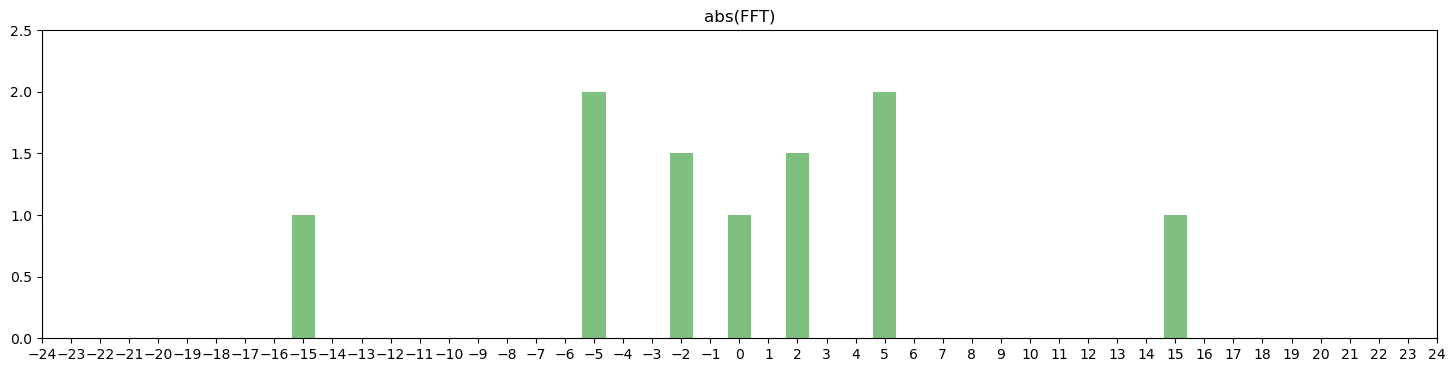

In [27]:
n = len(F)
n2 = (n+1) // 2
w = np.array(range(len(F)))
ws = np.roll(w,n2)
Fs = np.roll(F,n2)
fig(18,4)
plt.bar(w-25,abs(Fs), color='green',alpha=0.5)
plt.xticks(w-25); 
plt.axis([-24,24,0,2.5]);
plt.title('abs(FFT)');

Cuando la señal es real, como en este ejemplo, la FFT es simétrica conjugada. Las frecuencias negativas tienen la misma amplitud absoluta y podemos mostrar solo las frecuencias positivas:

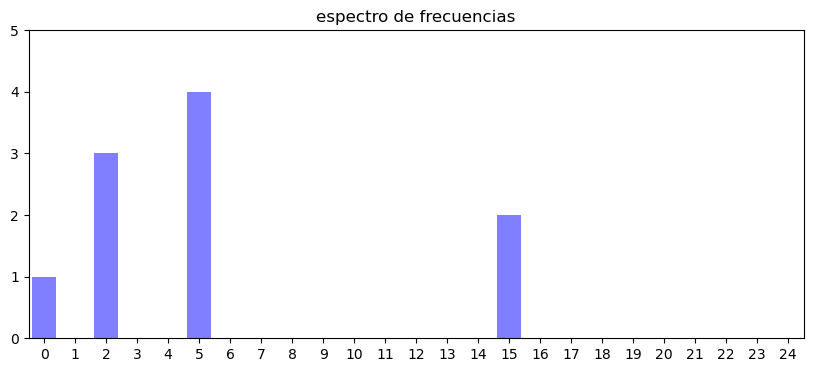

In [28]:
n2 = len(F)//2
P = abs(F)[:n2]
P[2:] *= 2
fig(10,4)
plt.bar(w[:n2],P, color='blue',alpha=0.5)
plt.xticks(w[:n2]); 
plt.axis([-.5,24.5,0,5]);
plt.title('espectro de frecuencias');

Estas amplitudes coinciden con los coeficientes utilizados para definir `fun`.

Si se toman $n$ muestras sólo se puede analizar hasta la frecuencia $n\over2$.

### Ortogonalidad

*Power spectrum*, *Parseval Theorem*. La energía de la señal se reparte entre las diferentes frecuencias:

$$\int_t \left|x(t)\right|^2 dt = \int_\omega \left|F(\omega)\right|^2 d \omega$$

Con transformación unitaria.

Normalizamos la transformación adecuadamente para que la inversa sea simplemente la directa de la entrada conjugada.

In [29]:
def myfft(x):
    return np.fft.fft(x)/np.sqrt(len(x))

def myifft(x):
    return myfft(np.conj(x))

Formamos la matriz de la transformación y vemos que efectivamente es unitaria.

In [30]:
matF = np.array([myfft(row) for row in np.eye(10)])

np.linalg.det(matF)

(-1-1.4944155847812955e-16j)

Esta es la señal muestreada que hemos creado más arriba:

La misma operación (con la conjugación) es la identidad.

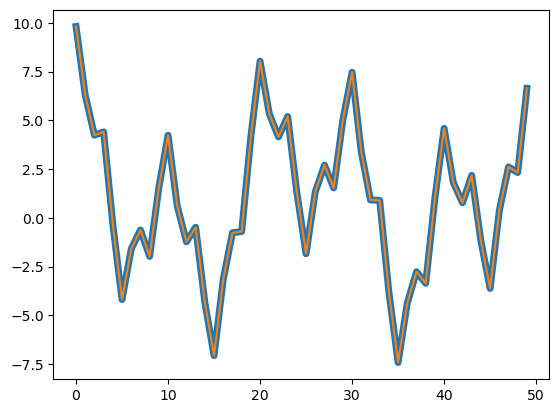

In [31]:
plt.plot(f,lw=5)
plt.plot(np.real(myifft(myfft(f))));

Y como debe ser, la TF preserva la norma.

In [32]:
np.linalg.norm(f), np.linalg.norm(myfft(f))

(27.838821814150105, 27.838821814150105)

### Armónicos

Consideremos ahora una señal periódica pero con forma de onda muy distinta de la sinusoidal.

In [33]:
x = np.arange(1000)
f = np.zeros_like(x)
f[x % 50 < 10] = 1

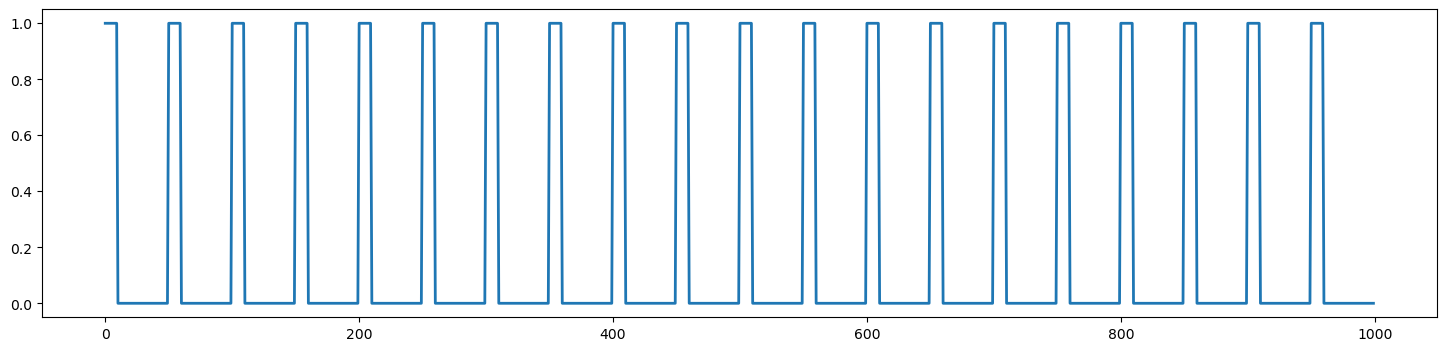

In [34]:
fig(18,4)
plt.plot(f,lw=2);

In [35]:
F = fft.fft(f)/len(f)

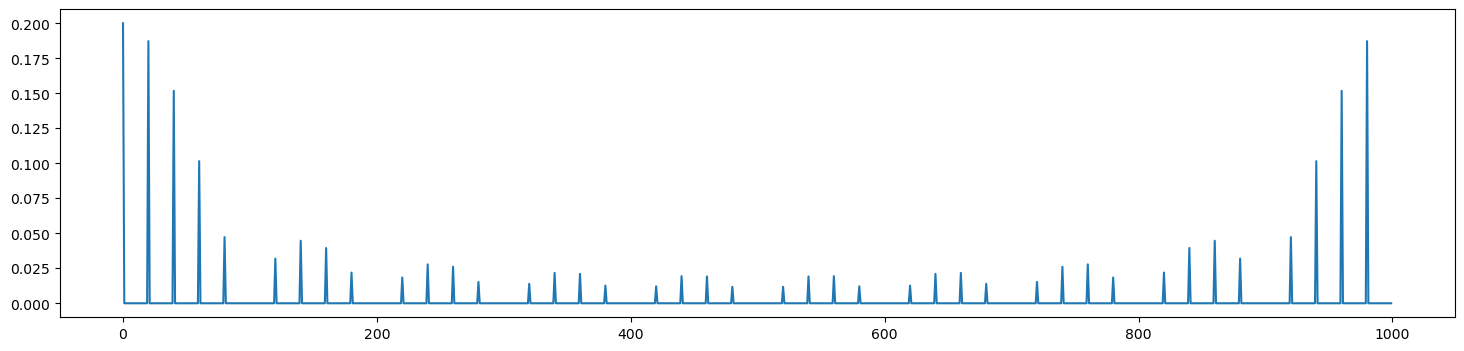

In [36]:
fig(18,4)
plt.plot(abs(F));

La frecuencia $20=1000/50$ se detecta perfectamente pero aparecen armónicos, múltiplos de la frecuencia fundamental.

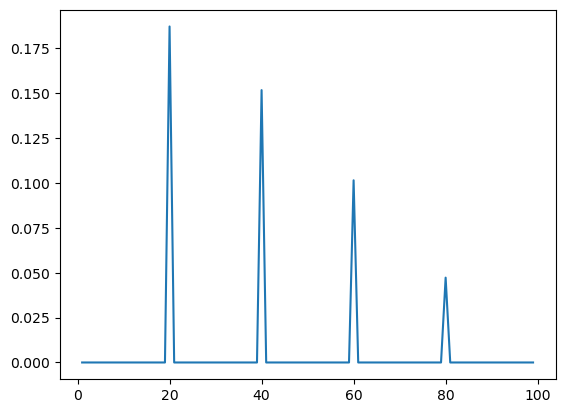

In [37]:
# frecuencias más bajas, quitando la constante
plt.plot(np.arange(1,100), abs(F)[1:100]);

### Modulación

(Este apartado es opcional)

Combinación de una portadora y una modulación no lineal, multiplicativa:

In [38]:
x = np.linspace(0,30,1000)
f = np.sin(2*np.pi*2*x) *np.sin(2*np.pi*0.1*x)
#f = np.sin(2*np.pi*0.1*x)

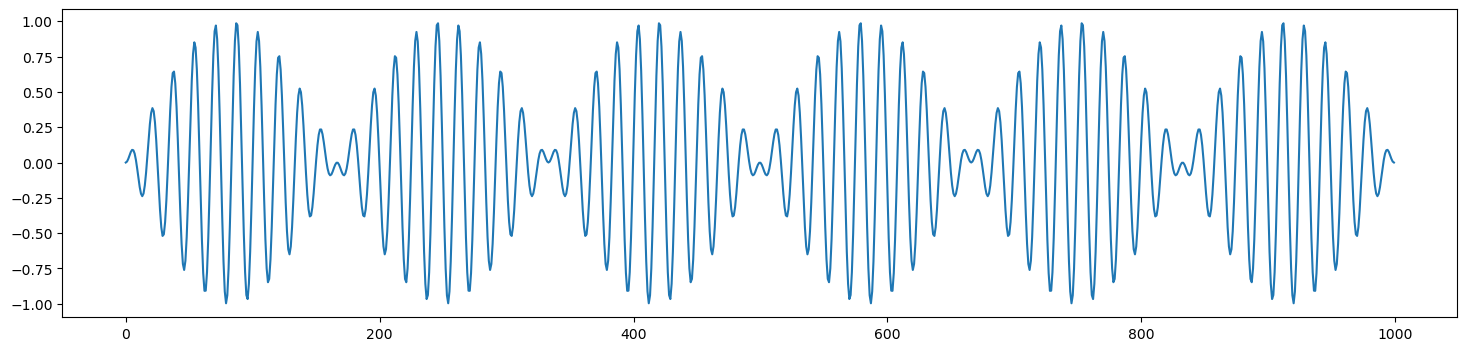

In [39]:
fig(18,4)
plt.plot(f);

In [40]:
F = fft.fft(f)/len(f)

C:\Users\l3rii\anaconda3\envs\VIA\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(array([ 57,  63, 937, 943], dtype=int64),)

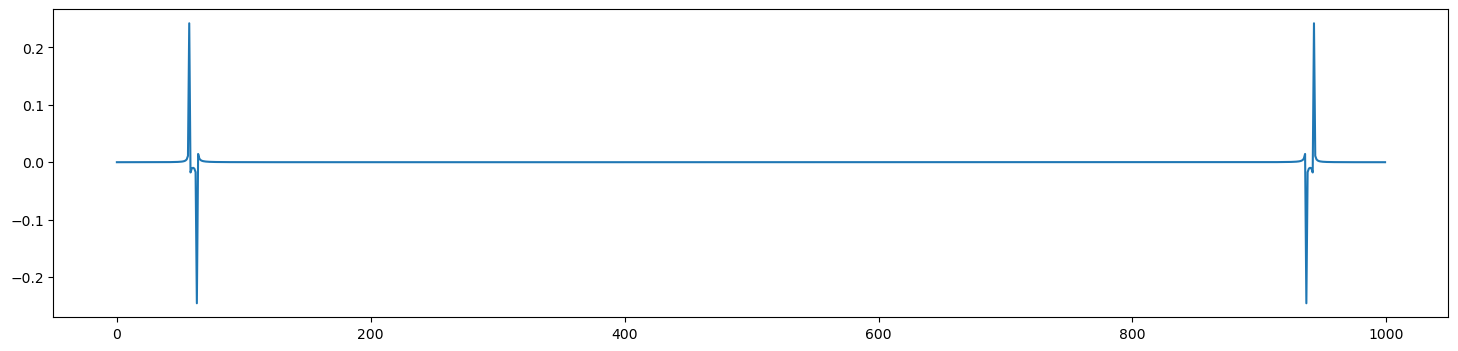

In [41]:
fig(18,4)
plt.plot(abs(F));
np.where(abs(F)>0.2)

Aparece, no por separado, sino $f_c + f_m$  y $f_c-f_m$.

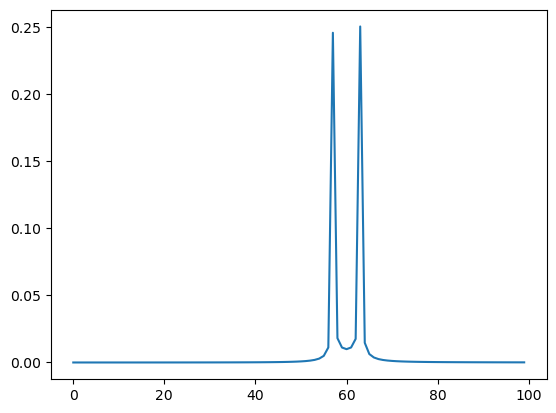

In [42]:
plt.plot(abs(F)[:100]);

(La portadora se ha generado con frecuencia 2 y el análisis es en 30 unidades, por tanto corresponde a la posición 60 de la transformada. La modulación, que tiene frecuencia 0.1 corresponde a la posición 3.)

### Transformada inversa

Podemos sintetizar ondas creando un vector con las amplitudes de cada frecuencia y aplicando la transformada inversa:

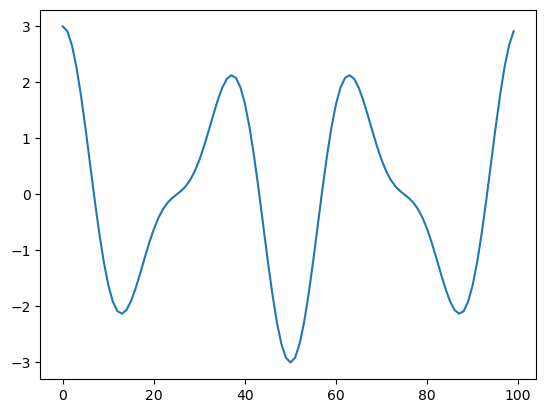

In [43]:
F = np.zeros(100,dtype=complex)
F[3] = 2
F[5] = 1
f = fft.ifft(F)*len(F)
plt.plot(np.real(f));

### Filtrado frecuencial

Generamos una señal de test:

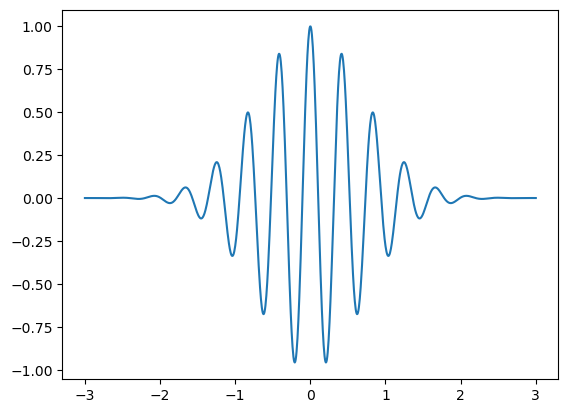

In [44]:
x = np.linspace(-3,3,1000)
s = np.exp(-x**2)*np.cos(15*x)
plt.plot(x,s);

La contaminamos con ruido gaussiano:

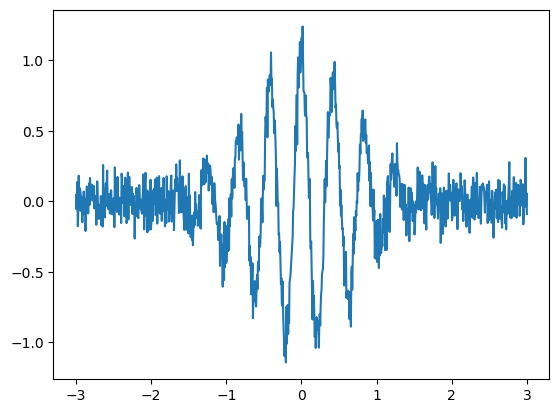

In [45]:
sr = s + 0.1*rnd.randn(len(s))
plt.plot(x,sr);

Nos gustaría "limpiar" esta señal ruidosa para recuperar una versión lo más parecida posible a la original. Esto se podría hacer de diferentes formas, pero aquí vamos a intentar hacerlo modificando su espectro de frecuencias. El ruido gaussiano es "blanco", tiene todas las frecuencias. Si sabemos cuál es el ancho de banda de la señal original podemos eliminar las demás frecuencias.

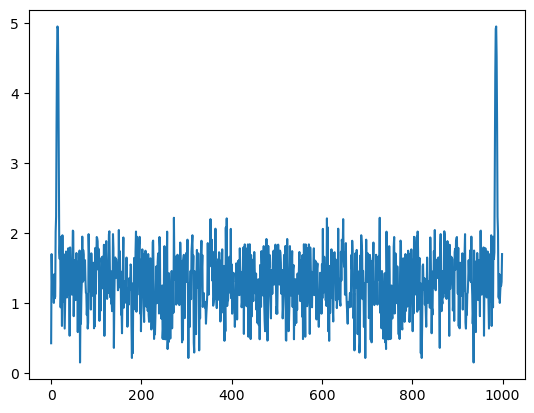

In [46]:
fsr = fft.fft(sr)
plt.plot(np.log(1+np.abs(fsr)));

Hagamos "zoom":

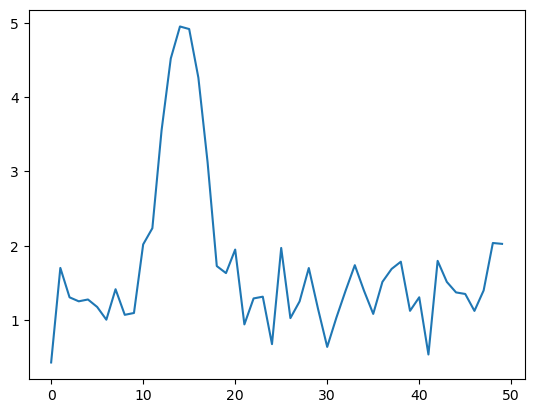

In [47]:
fsr = fft.fft(sr)
plt.plot(np.log(1+np.abs(fsr))[0:50]);

Parece que la señal llega hasta la frecuencia 20 más o menos. Anulamos todas las mayores y reconstruimos:

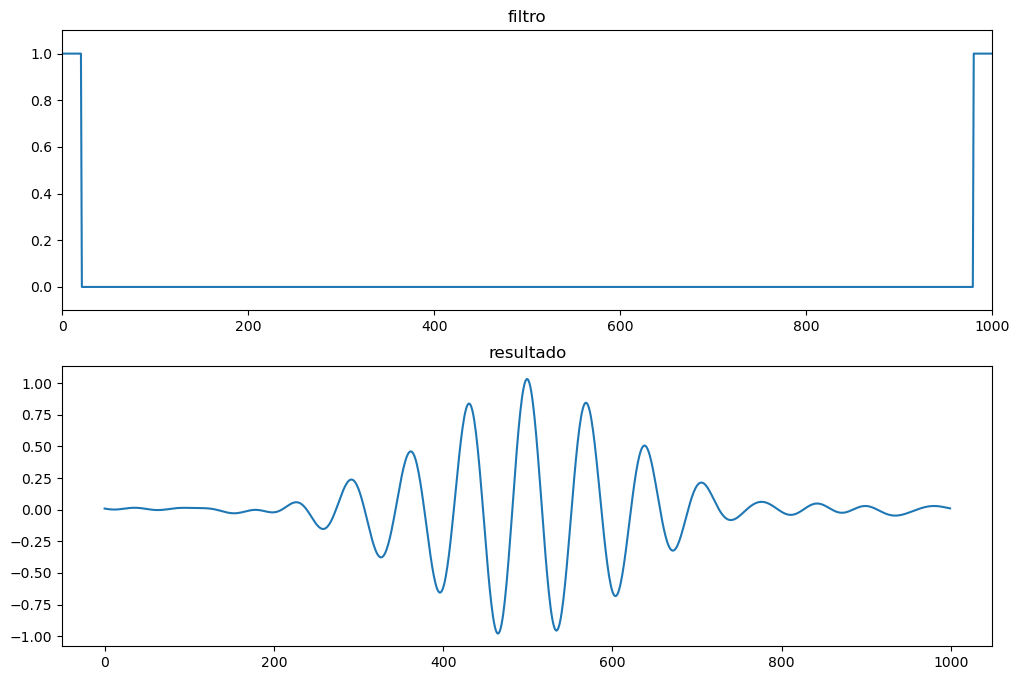

In [48]:
fig(12,8)
fil = np.ones(len(fsr))
c = 21
fil[c:-(c-1)] = 0
plt.subplot(2,1,1)
plt.plot(fil); plt.axis([0,1000,-0.1,1.1]); plt.title('filtro')
plt.subplot(2,1,2)
plt.plot(np.real(fft.ifft(fsr*fil))); plt.title('resultado');

Si conocemos el espectro de la señal original podríamos filtrar con mayor precisión.

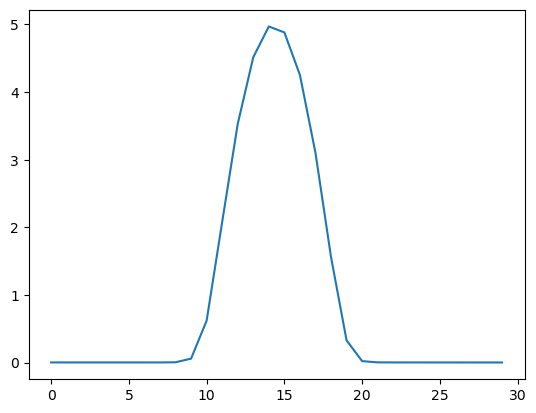

In [49]:
plt.plot(np.log(1+np.abs(fft.fft(s)[0:30])));

Vemos que solo tiene componentes apreciables en las frecuencias desde 9 hasta 19. El resto se puede eliminar.

En la práctica no se debe filtrar tan bruscamente, es mejor atenuar frecuencias de forma gradual.

### Correlación

Comprobamos que podemos calcular eficientemente la correlación entre dos señales en el dominio de la frecuencia.

Creamos una señal del prueba y la desplazamos un número de muestras predeterminado.

In [50]:
def gauss(x,m,s):
    return np.exp(-0.5*((x-m)/s)**2)

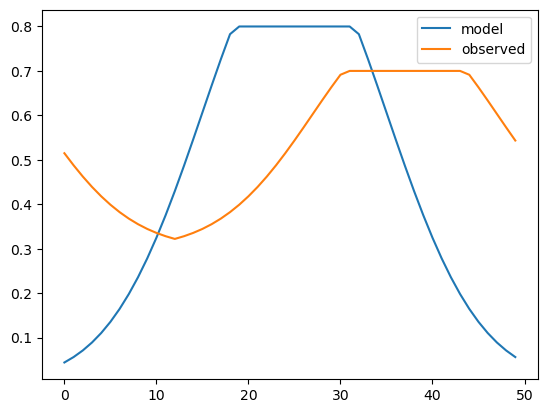

In [51]:
D = 12

#x = f
x = gauss(np.arange(50),25,10)
x = np.clip(x,0,0.8)
xo = np.roll(x,D)/2+0.3

plt.plot(x,label='model')
plt.plot(xo,label='observed');
plt.legend();

Vemos el resultado intermedio, el producto de transformadas:

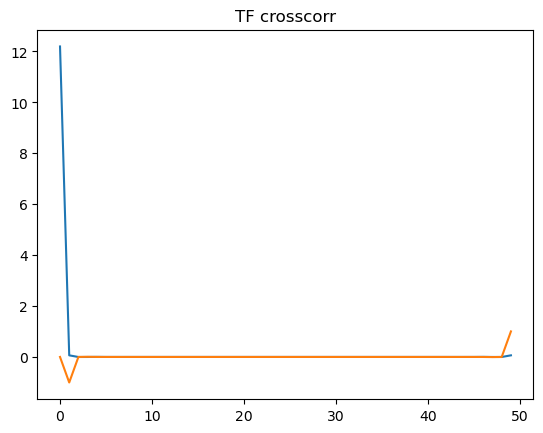

In [52]:
Fx =  myfft(x)
Fxo = myfft(xo)
Fcorr = np.conj(Fx) * (Fxo)

plt.plot(np.real(Fcorr)); plt.plot(np.imag(Fcorr))
plt.title("TF crosscorr");

Y pasamos la correlación al dominio espacial. La posición de máxima correlación detecta perfectamente el desplazamiento que hemos introducido.

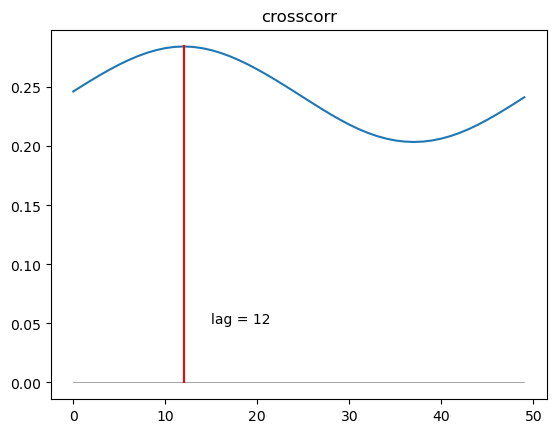

In [53]:
corr = np.real(np.fft.ifft(Fcorr))
d = np.argmax(corr)

plt.plot(corr);
plt.plot(corr*0,color='gray',lw=0.5)
plt.plot([d,d],[0,corr[d]],color='red');
plt.title('crosscorr')
plt.text(15,0.05,f"lag = {d}");

En los "discriminative correlation filters" deseamos una respuesta mucho más afilada en la posición de máxima correlación:

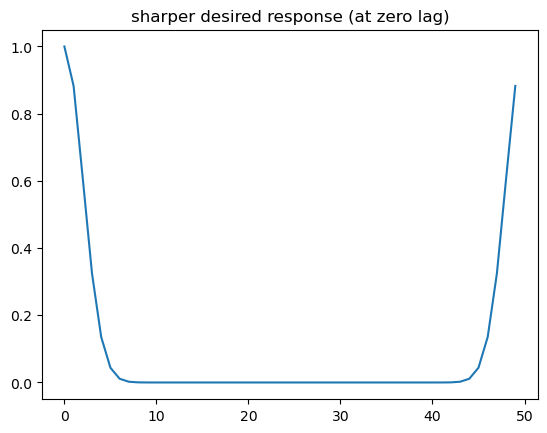

In [54]:
y = np.roll(gauss(np.arange(len(x)),25,2),25)

plt.plot(y);
plt.title("sharper desired response (at zero lag)");

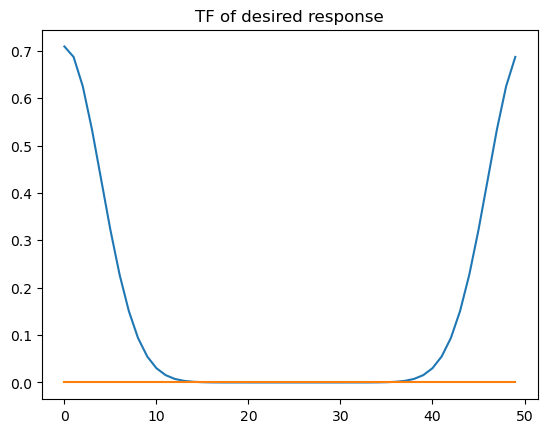

In [55]:
Fy = myfft(y)

plt.plot(np.real(Fy)); plt.plot(np.imag(Fy));
plt.title("TF of desired response");

El filtro "ingenuo" que simplemente divide la respuesta deseada por la señal (en el dominio de la frecuencia) se puede encontrar con divisiones por cero:

min abs value (denominator): 5.2060066298378076e-05


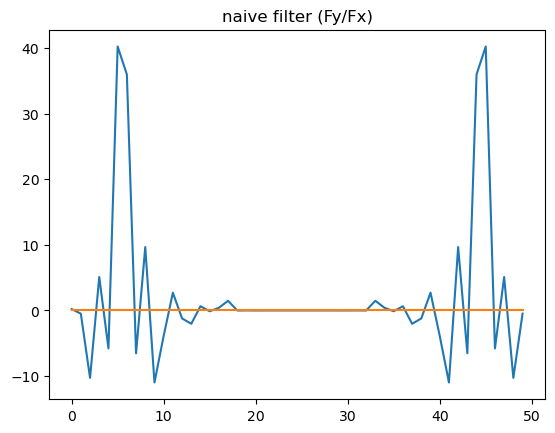

In [56]:
print(f"min abs value (denominator): {np.abs(Fx).min()}")
filtro = Fy / Fx

plt.plot(np.real(filtro)); plt.plot(np.imag(filtro));
plt.title("naive filter (Fy/Fx)");

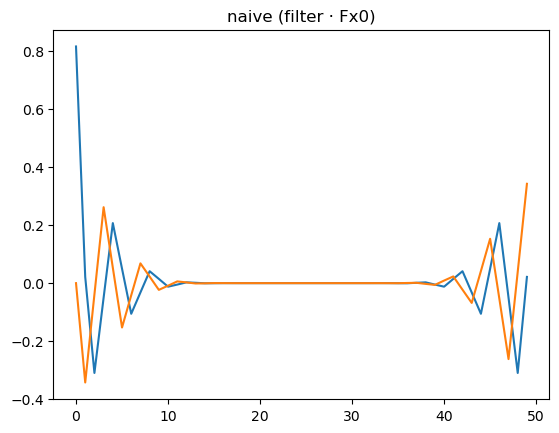

In [57]:
Fcorr = filtro * (Fxo)

plt.plot(np.real(Fcorr)); plt.plot(np.imag(Fcorr))
plt.title("naive (filter · Fx0)");

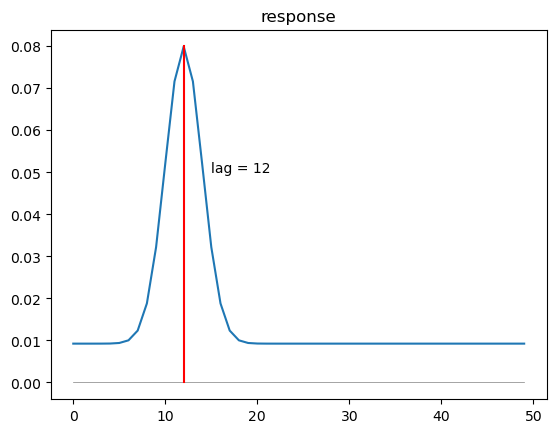

In [58]:
corr = np.real(np.fft.ifft(Fcorr))
d = np.argmax(corr)

plt.plot(corr);
plt.plot(corr*0,color='gray',lw=0.5)
plt.plot([d,d],[0,corr[d]],color='red');
plt.text(15,0.05,f"lag = {d}")
plt.title('response');

Funciona bien pero es numéricamente instable. Es preferible obtener una solución regularizada.

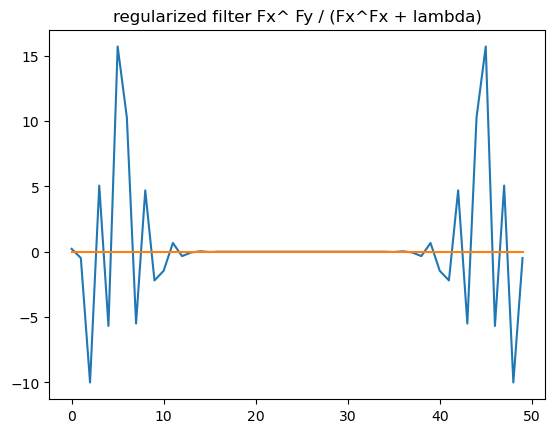

In [59]:
filtro = np.conj(Fx)*(Fy) / (Fx*np.conj(Fx) + 1E-4)

plt.plot(np.real(filtro)); plt.plot(np.imag(filtro));
plt.title("regularized filter Fx^ Fy / (Fx^Fx + lambda)");

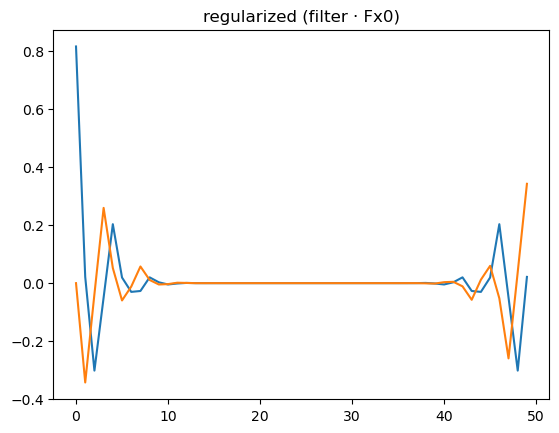

In [60]:
Fcorr = filtro * (Fxo)

plt.plot(np.real(Fcorr)); plt.plot(np.imag(Fcorr))
plt.title("regularized (filter · Fx0)");

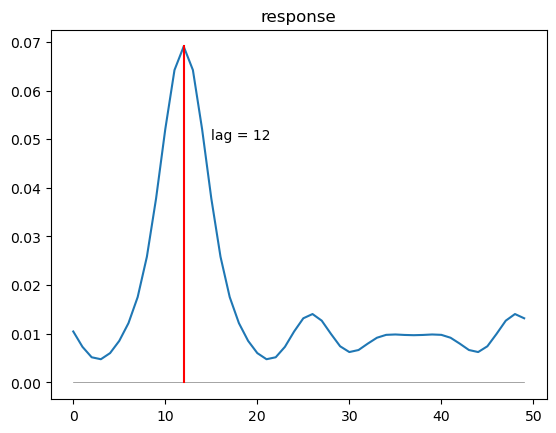

In [61]:
corr = np.real(np.fft.ifft(Fcorr))
d = np.argmax(corr)

plt.plot(corr);
plt.plot(corr*0,color='gray',lw=0.5)
plt.plot([d,d],[0,corr[d]],color='red');
plt.text(15,0.05,f"lag = {d}")
plt.title('response');

Estas comprobaciones se hacen con señales periódicas. En aplicaciones reales con señales arbitrarias podemos usar una "ventana" que anula los extremos.

### Señales 2D

Cuando trabajamos con señales bidimensionales (imágenes) las componentes frecuenciales son ondas planas en diferentes direcciones, frecuencias y desplazamientos:

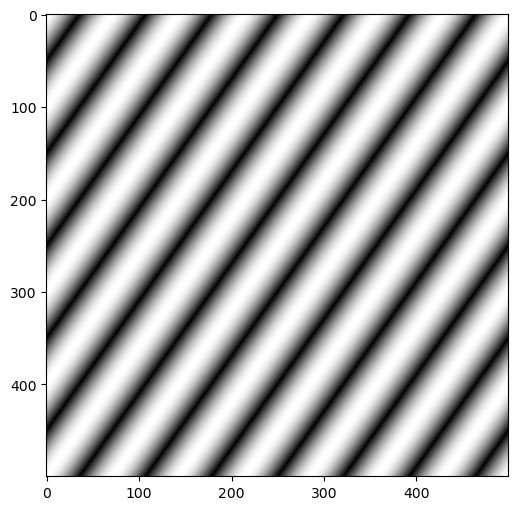

In [62]:
F = np.zeros([500,500])
F[3,4] = 1; F[-2,-3] = 1
#F[4,6] = 1; F[-3,-5] = 1
#F[1,2] = 1; F[-1,-2] = 1
f = ift(F)
fig(6,6)
plt.imshow(np.abs(f),'gray');

[Este vídeo](https://www.youtube.com/watch?v=D9ziTuJ3OCw) muestra la reconstrucción de una imagen a partir de estas ondas. Intenta descubrir quién es el personaje antes de que tenga suficiente detalle.

Si la imagen tiene un patrón repetido uniforme su orientación y frecuencia se puede descubrir en la FFT.

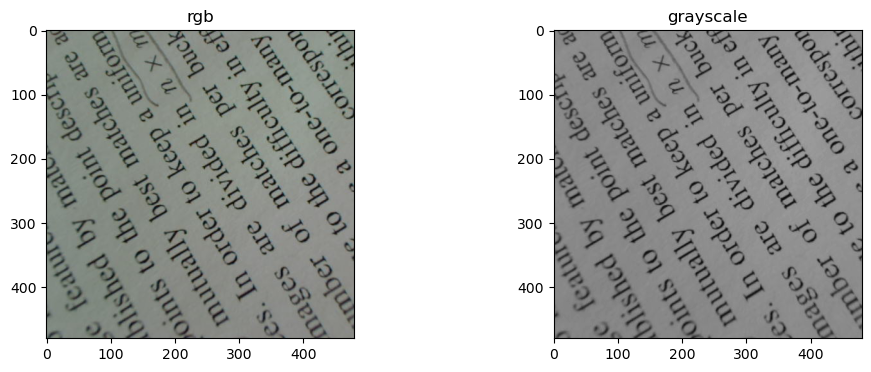

In [63]:
img = readrgb('texto/borroso0.png')
n = min(img.shape[:2])
img = img[:n,:n]
#img = readrgb('d2.jpg')[0:800,0:800]


fig(12,4)
plt.subplot(1,2,1); plt.imshow(img); plt.title('rgb')
g = rgb2gray(img)
f = gray2float(g)
plt.subplot(1,2,2); imshowf(f); plt.title('grayscale');

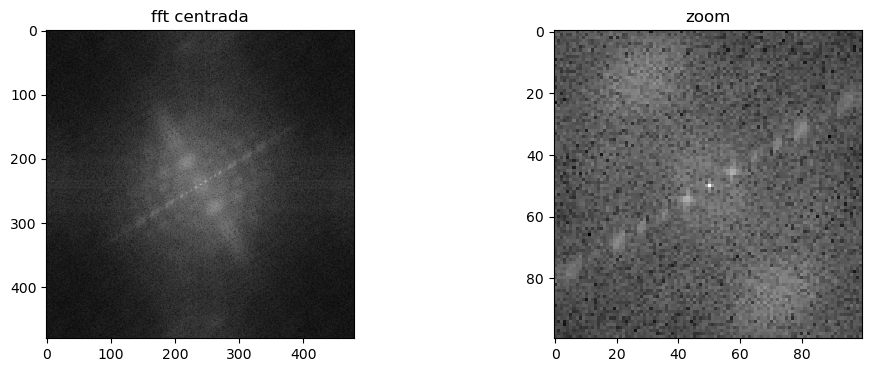

In [64]:
ff = np.log(1+abs(ft(f)))
#ff[0,0] = 0
r,c = ff.shape
r2 = r // 2
c2 = c // 2

fig(12,4)
plt.subplot(1,2,1); imshowg(centrafft(ff)); plt.title('fft centrada')
plt.subplot(1,2,2); imshowg(centrafft(ff)[r2-50:r2+50,c2-50:c2+50]); plt.title('zoom');

Los picos más cercanos al origen nos dan la dirección y frecuencia de la oscilación fundamental. Esto puede utilizarse para corregir la orientación del texto anterior.

El ejemplo de código `code/spectral.py` muestra en vivo la fft 2D de la imagen de entrada.

## misc

- clasificación de trazos

- cambiar fase vs cambiar amplitud

- [imágenes híbridas](http://jeremykun.com/2014/09/29/hybrid-images/)